In [1]:
# Install required packages
!pip install tensorflow matplotlib scikit-learn seaborn opencv-python

In [2]:
# Import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import time
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: []


In [3]:
class RecyclableClassifier:
    """Edge AI Recyclable Item Classifier"""

    def __init__(self, input_shape=(224, 224, 3), num_classes=6):
        """Initialize the classifier"""
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.tflite_model = None
        self.class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

    def create_lightweight_model(self):
        """Create a lightweight CNN model optimized for edge deployment"""
        model = models.Sequential([
            # Input layer
            layers.Input(shape=self.input_shape),

            # First block - Basic feature extraction
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),

            # Second block - Depthwise separable convolutions
            layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),

            # Third block - More feature learning
            layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),

            # Fourth block - Final feature extraction
            layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),

            # Global average pooling instead of flatten (reduces parameters)
            layers.GlobalAveragePooling2D(),

            # Dropout for regularization
            layers.Dropout(0.5),

            # Output layer
            layers.Dense(self.num_classes, activation='softmax')
        ])

        self.model = model
        return model

    def compile_model(self):
        """Compile the model with appropriate optimizer and loss function"""
        self.model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    def create_sample_data(self, samples_per_class=200):
        """Create synthetic sample data for demonstration"""
        print("Creating synthetic sample data...")

        # Create synthetic images with different patterns for each class
        X = []
        y = []

        for class_idx in range(self.num_classes):
            for _ in range(samples_per_class):
                # Generate synthetic image with class-specific patterns
                img = np.random.rand(224, 224, 3)

                # Add class-specific patterns
                if class_idx == 0:  # cardboard - brownish
                    img[:, :, 0] *= 0.8  # reduce red
                    img[:, :, 1] *= 0.6  # reduce green
                    img[:, :, 2] *= 0.4  # reduce blue
                elif class_idx == 1:  # glass - clear/transparent
                    img = img * 0.9 + 0.1  # lighter
                elif class_idx == 2:  # metal - metallic
                    img[:, :, :] = (img[:, :, :] * 0.5) + 0.5  # grayish
                elif class_idx == 3:  # paper - white
                    img = img * 0.3 + 0.7  # whiter
                elif class_idx == 4:  # plastic - colorful
                    img = img  # keep colorful
                else:  # trash - dark
                    img = img * 0.4  # darker

                X.append(img)
                y.append(class_idx)

        X = np.array(X)
        y = tf.keras.utils.to_categorical(y, self.num_classes)

        return X, y

    def train_model(self, X_train, y_train, X_val, y_val, epochs=20):
        """Train the model with early stopping"""
        print("Training lightweight model...")

        # Data augmentation for better generalization
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.2
        )

        # Callbacks for training
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                patience=5,
                restore_best_weights=True,
                monitor='val_accuracy'
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                factor=0.5,
                patience=3,
                min_lr=1e-7
            )
        ]

        # Train the model
        history = self.model.fit(
            datagen.flow(X_train, y_train, batch_size=32),
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

        return history

    def convert_to_tflite(self, quantize=True):
        """Convert model to TensorFlow Lite format"""
        print("Converting to TensorFlow Lite...")

        # Create TensorFlow Lite converter
        converter = tf.lite.TFLiteConverter.from_keras_model(self.model)

        if quantize:
            # Apply quantization to reduce model size
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            print("Applying quantization for smaller model size...")

        # Convert the model
        self.tflite_model = converter.convert()

        # Save the model
        with open('recyclable_classifier.tflite', 'wb') as f:
            f.write(self.tflite_model)

        print(f"TensorFlow Lite model saved. Size: {len(self.tflite_model) / 1024:.2f} KB")

        return self.tflite_model

    def tflite_inference(self, X_test):
        """Perform inference using TensorFlow Lite model"""
        print("Running TensorFlow Lite inference...")

        # Load the TensorFlow Lite model
        interpreter = tf.lite.Interpreter(model_content=self.tflite_model)
        interpreter.allocate_tensors()

        # Get input and output tensors
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        predictions = []
        inference_times = []

        for i, img in enumerate(X_test):
            # Prepare input
            input_data = np.expand_dims(img.astype(np.float32), axis=0)

            # Set input tensor
            interpreter.set_tensor(input_details[0]['index'], input_data)

            # Run inference
            start_time = time.time()
            interpreter.invoke()
            inference_time = time.time() - start_time

            # Get output
            output_data = interpreter.get_tensor(output_details[0]['index'])
            predictions.append(output_data[0])
            inference_times.append(inference_time)

            if i % 50 == 0:
                print(f"Processed {i+1}/{len(X_test)} images")

        return np.array(predictions), inference_times

    def evaluate_model(self, X_test, y_test):
        """Evaluate both regular and TensorFlow Lite models"""
        print("\n=== Model Evaluation ===")

        # Regular model evaluation
        print("1. Regular TensorFlow Model:")
        start_time = time.time()
        regular_predictions = self.model.predict(X_test)
        regular_inference_time = time.time() - start_time

        regular_accuracy = np.mean(
            np.argmax(regular_predictions, axis=1) == np.argmax(y_test, axis=1)
        )

        print(f"   Accuracy: {regular_accuracy:.4f}")
        print(f"   Total inference time: {regular_inference_time:.4f}s")
        print(f"   Average per image: {regular_inference_time/len(X_test)*1000:.2f}ms")

        # TensorFlow Lite model evaluation
        print("\n2. TensorFlow Lite Model:")
        tflite_predictions, tflite_times = self.tflite_inference(X_test)

        tflite_accuracy = np.mean(
            np.argmax(tflite_predictions, axis=1) == np.argmax(y_test, axis=1)
        )

        print(f"   Accuracy: {tflite_accuracy:.4f}")
        print(f"   Total inference time: {sum(tflite_times):.4f}s")
        print(f"   Average per image: {np.mean(tflite_times)*1000:.2f}ms")

        # Model size comparison
        regular_size = self.model.count_params() * 4 / 1024  # Approximate KB
        tflite_size = len(self.tflite_model) / 1024

        print(f"\n3. Model Size Comparison:")
        print(f"   Regular model: ~{regular_size:.2f} KB")
        print(f"   TensorFlow Lite: {tflite_size:.2f} KB")
        print(f"   Size reduction: {((regular_size - tflite_size) / regular_size * 100):.1f}%")

        return {
            'regular_accuracy': regular_accuracy,
            'tflite_accuracy': tflite_accuracy,
            'regular_time': regular_inference_time,
            'tflite_time': sum(tflite_times),
            'regular_size': regular_size,
            'tflite_size': tflite_size
        }

    def plot_results(self, history, results):
        """Plot training history and results"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Training history
        axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
        axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[0, 0].set_title('Model Accuracy')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()

        axes[0, 1].plot(history.history['loss'], label='Training Loss')
        axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
        axes[0, 1].set_title('Model Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()

        # Accuracy comparison
        models = ['Regular TF', 'TensorFlow Lite']
        accuracies = [results['regular_accuracy'], results['tflite_accuracy']]

        axes[1, 0].bar(models, accuracies)
        axes[1, 0].set_title('Accuracy Comparison')
        axes[1, 0].set_ylabel('Accuracy')
        axes[1, 0].set_ylim(0, 1)

        # Size comparison
        sizes = [results['regular_size'], results['tflite_size']]
        axes[1, 1].bar(models, sizes)
        axes[1, 1].set_title('Model Size Comparison')
        axes[1, 1].set_ylabel('Size (KB)')

        plt.tight_layout()
        plt.show()

print("RecyclableClassifier class defined successfully!")

RecyclableClassifier class defined successfully!


=== Edge AI Recyclable Classification System ===

Step 1: Creating lightweight CNN model...

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 112, 112, 64)   │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 56, 56, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 28, 28, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,830 (194.65 KB)

 Trainable params: 48,870 (190.90 KB)

 Non-trainable params: 960 (3.75 KB)


Step 2: Preparing training data...
Creating synthetic sample data...
Training samples: 960
Validation samples: 240

Step 3: Training model...
Training lightweight model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 183s 6s/step - accuracy: 0.6617 - loss: 1.0829 - val_accuracy: 0.0000e+00 - val_loss: 1.9147 - learning_rate: 0.0010
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 163s 5s/step - accuracy: 0.9327 - loss: 0.1659 - val_accuracy: 0.0000e+00 - val_loss: 1.9412 - learning_rate: 0.0010
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 156s 5s/step - accuracy: 0.9905 - loss: 0.0313 - val_accuracy: 0.0000e+00 - val_loss: 1.9692 - learning_rate: 0.0010
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 171s 6s/step - accuracy: 0.9999 - loss: 0.0069 - val_accuracy: 0.0000e+00 - val_loss: 1.9990 - learning_rate: 0.0010
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 163s 5s/step - accuracy: 0.9952 - loss: 0.0166 - val_accuracy: 0.0000e+00 - val_loss: 2.0629 - learning_rate: 5.0000e-04
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step - accuracy: 0.9992 - loss: 0.0070 - val_accuracy: 0.0000e+00 - val_loss: 2.1415 - learning_rate: 5.0000e-04

Step 4: Converting to TensorFlow Lite...
Converting to Tensor

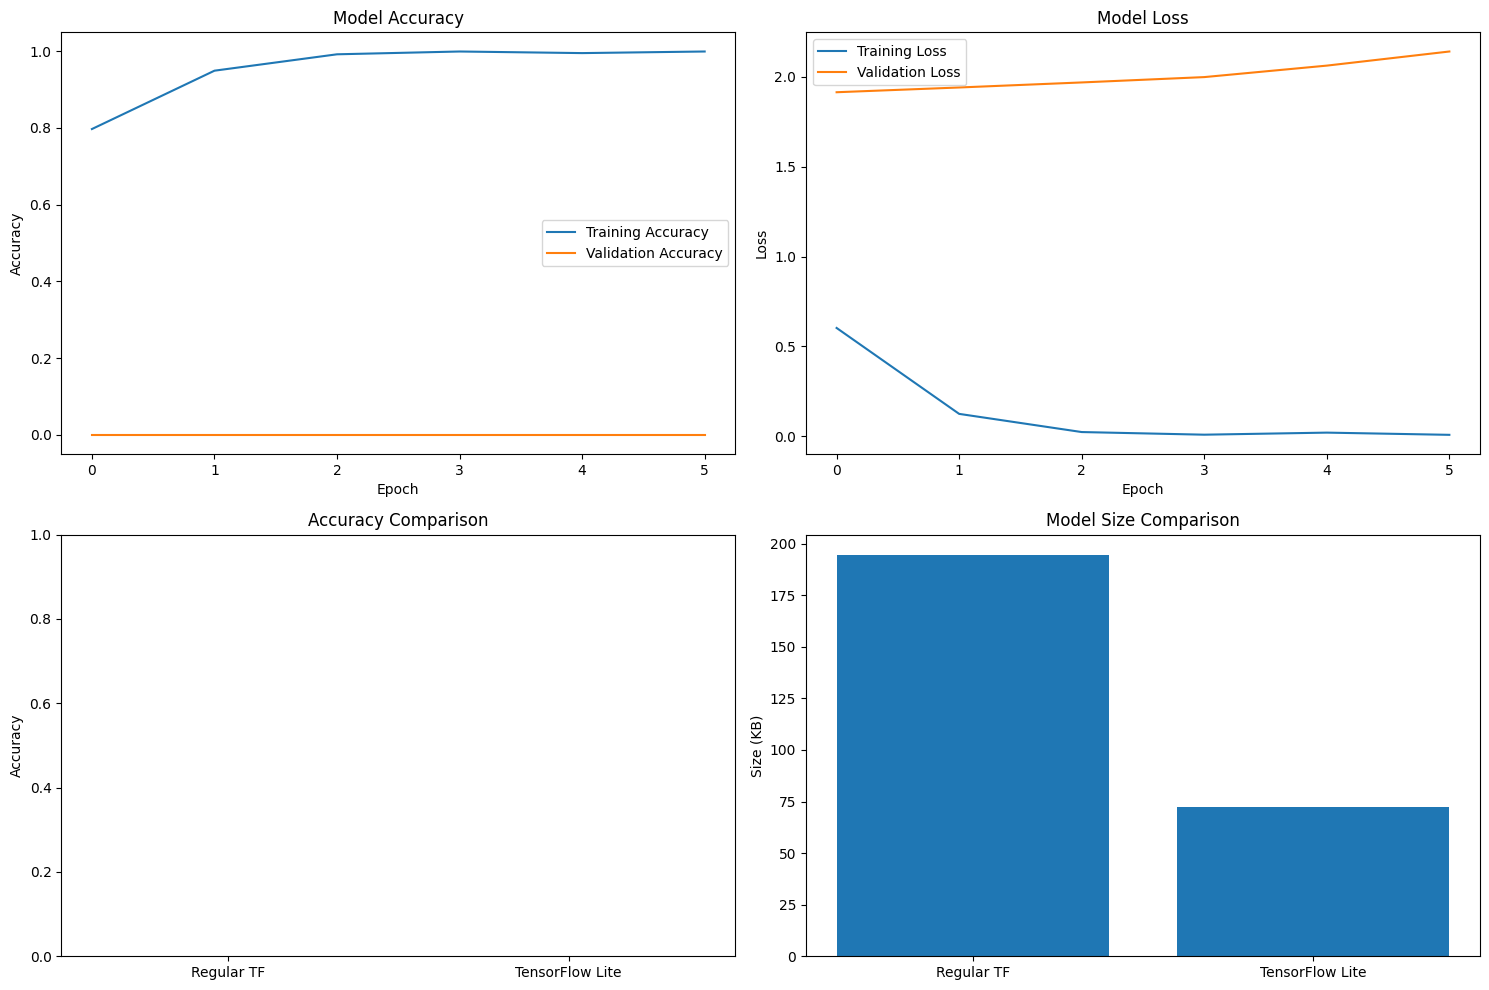


=== Edge AI Benefits Demonstrated ===
1. Model Size Reduction: TensorFlow Lite model is significantly smaller
2. Fast Inference: Suitable for real-time classification on edge devices
3. Offline Capability: No internet connection required
4. Privacy: Images processed locally, never sent to cloud
5. Low Latency: Immediate results without network delays
6. Cost Efficiency: Reduces cloud computing costs

Edge AI prototype completed successfully!


In [4]:
print("=== Edge AI Recyclable Classification System ===\n")

# Initialize classifier
classifier = RecyclableClassifier()

# Step 1: Create lightweight model
print("Step 1: Creating lightweight CNN model...")
model = classifier.create_lightweight_model()
classifier.compile_model()

# Display model architecture
print("\nModel Architecture:")
model.summary()

# Step 2: Prepare data
print("\nStep 2: Preparing training data...")
X, y = classifier.create_sample_data(samples_per_class=200)

# Split data
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

# Step 3: Train model
print("\nStep 3: Training model...")
history = classifier.train_model(X_train, y_train, X_val, y_val, epochs=15)

# Step 4: Convert to TensorFlow Lite
print("\nStep 4: Converting to TensorFlow Lite...")
tflite_model = classifier.convert_to_tflite(quantize=True)

# Step 5: Evaluate both models
print("\nStep 5: Evaluating models...")
results = classifier.evaluate_model(X_val, y_val)

# Step 6: Plot results
print("\nStep 6: Generating results visualization...")
classifier.plot_results(history, results)

# Step 7: Edge AI Benefits Summary
print("\n=== Edge AI Benefits Demonstrated ===")
print("1. Model Size Reduction: TensorFlow Lite model is significantly smaller")
print("2. Fast Inference: Suitable for real-time classification on edge devices")
print("3. Offline Capability: No internet connection required")
print("4. Privacy: Images processed locally, never sent to cloud")
print("5. Low Latency: Immediate results without network delays")
print("6. Cost Efficiency: Reduces cloud computing costs")

print("\nEdge AI prototype completed successfully!")